# Impact of different initial states

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, random_statevector, random_density_matrix

from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
from quantum_simulation_recipe.trotter import pf, expH
from quantum_simulation_recipe.bounds import norm

import matplotlib.pyplot as plt
from quantum_simulation_recipe.plot_config import *

cc = ['#9467bdFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#ff7f0eFF', '#8c564bFF', '#e377c2FF', '#7f7f7fFF', '#bcbd22FF', '#17becfFF']
set_fontsize(medium=MEDIUM_SIZE+6, large=LARGE_SIZE+6, linewidth=2.5)
plt.rc('legend', fontsize=MEDIUM_SIZE) 

# mpl.rcParams['legend.frameon'] = False
# mpl.rcParams['font.family'] = 'sans-serif' 

fig_dir, data_dir = './figs', './data'

from metric import WeakDiamondDistance, worst_state, worst_holistic, worst_state_svd
# from distance import WeakDiamondDistance

Matplotlib is building the font cache; this may take a moment.


## Select model and set parameters

In [2]:
# select model
model = 'nnh'
n = 8
# n = 10

if model == 'nnh':
    J, h, pbc, group = 2, 1, True, 'xyz' # 'parity' 'xyz'
    # J, h, pbc, group = 2, 1, True, 'parity' # 'parity' 'xyz'
    model_par = {'Jz': J, 'hx': h, 'pbc': pbc}
    nnh = Nearest_Neighbour_1d(n, Jz=J, hx=h, pbc=pbc)
    if group == 'parity':
        H_list = [term.to_matrix() for term in nnh.ham_par]
    else:
        H_list = [term.to_matrix() for term in nnh.ham_xyz]

elif model == 'power_law':
    alpha, hz = 4, 0.2
    model_par = {'alpha': alpha, 'hz': hz, 'Jx': 1, 'Jy': 1, 'Jz': 1}
    from quantum_simulation_recipe.spin import Power_Law
    pl = Power_Law(n, alpha=alpha, hz=hz, Jx=1, Jy=1, Jz=1)
    H_list = [term.to_matrix() for term in pl.ham_xyz]
elif model == 'fermi_hubbard':
    J, U = -1, 1
    model_par = {'U': U}
    assert n % 2 == 0
    from quantum_simulation_recipe.fermion import hubbard_openfermion
    hubbard = hubbard_openfermion(n//2, U=U)
    H_list = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse), sum(hubbard.two_body_sparse)]
elif model == 'hydrogen_chain':
    assert n % 2 == 0
    chain_length, bond_length = n//2, 1.2
    model_par = {'chain_length': chain_length, 'bond_length': bond_length}
    from quantum_simulation_recipe.fermion import Hydrogen_Chain
    hc = Hydrogen_Chain(chain_length=chain_length, bond_length=bond_length)
    H_list = [term.toarray() for term in hc.h_group]
else:
    raise ValueError('Invalid model.')


## Trotter and data storage

In [3]:
# parameters
gamma = 5e-3
# gamma = 5e-7
t, r = n, 100
dt = t/r
t_list = np.arange(0, r)  * dt

# single-step exact U and approximate U
U_dt_appro = pf(H_list, dt, 1)
U_dt_exact = expH(sum(H_list), dt)

# all steps exact U and approximate U
U_appro = pf(H_list, t, r)
U_exact = expH(sum(H_list), t)

print('norm of U_dt_appro to U_dt_exact: ', norm(U_dt_appro - U_dt_exact))
print('norm of U_appro to U_exact: ', norm(U_appro - U_exact))

norm of U_dt_appro to U_dt_exact:  0.009363804872557942
norm of U_appro to U_exact:  0.2666427112595569


## Test zero input

In [18]:
from metric import alg_err

zero_input = DensityMatrix(Statevector.from_label('0'*n))

zero_all_err = alg_err(U_appro, U_exact, zero_input)

print('zero_all_err: ', zero_all_err)

zero_all_err:  0.07087877516041513


## Initial states

In [52]:
## input (initial) states
from states import ghz_state, random_states, ground_state

zero_input = DensityMatrix(Statevector.from_label('0'*n))   # .to_operator().to_matrix()
# plus_input = DensityMatrix(Statevector.from_label('+'*n))
# unif_input = DensityMatrix(Statevector.from_label('+'*n))
# ghz_input = DensityMatrix(ghz_state(n, verbose=False))
gnd_input = DensityMatrix(ground_state(sum(H_list), verbose=False))
wst_one_input = worst_state(U_dt_exact, U_dt_appro)
# wst_one_input = worst_state_svd(U_dt_exact, U_dt_appro, return_vec=False, verbose=True)
# wst_all_input = worst_holistic(U_exact, U_appro)

# rnd_input = random_states(n, 20, is_rho=True, verbose=False)
rnd_input = [DensityMatrix(st) for st in random_states(n, 20, verbose=False)]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.502217442457763
            Iterations: 23
            Function evaluations: 11802
            Gradient evaluations: 23
Optimal distance:  0.00936370373775531


In [ ]:
print('compare worst state...')
wst_one_input_test = worst_state_svd(U_dt_exact, U_dt_appro, return_vec=True, verbose=True)
print('vector error: ', np.linalg.norm(U_dt_appro @ wst_one_input_test - U_dt_exact @ wst_one_input_test, ord=2))
# print(np.linalg.norm(U_dt_appro.conj().T @ wst_one_input @ U_dt_appro - U_dt_exact.conj().T @ wst_one_input @ U_dt_exact, ord='nuc'))
wst_one_dm_test = DensityMatrix(wst_one_input_test).data
print('density matrix error: ', np.linalg.norm(U_dt_appro @ wst_one_dm_test @ U_dt_appro.conj().T - U_dt_exact @ wst_one_dm_test @ U_dt_exact.conj().T, ord='nuc'))

0.00936380487255794
achieve spectral norm (square root of largest eigenval):  0.009363804872557951
0.009363804872557719
0.0005599434144345745


Note: 
- runtime 10 secs for n=6
- runtime 40 mins for n=8

## Evolution

In [53]:
from evolution import Evolve_state
# from observable_decay import Evolve_state
# ob = SparsePauliOp( 'I'*(n-1) + 'X' , 1 ).to_matrix()

# zero_data = Evolve_state(U_dt_appro, U_dt_exact, r, zero_input, False, gamma)
zero_data = Evolve_state(U_dt_appro, U_dt_exact, r, zero_input, gamma, 2, t)
print('====================')
# plus_data = Evolve_state(U_dt_appro, U_dt_exact, r, plus_input, True, gamma)
# unif_data = Evolve_state(U_dt_appro, U_dt_exact, r, unif_input, True, gamma)
# ghz_data = Evolve_state(U_dt_appro, U_dt_exact, r, ghz_input, True, gamma)
gnd_data = Evolve_state(U_dt_appro, U_dt_exact, r, gnd_input, gamma, 2, t)
wst_one_data = Evolve_state(U_dt_appro, U_dt_exact, r, wst_one_input, gamma, 2, t)
# wst_all_data = Evolve_state(U_dt_appro, U_dt_exact, r, wst_all_input, True, gamma)

res_rand = {'phy': [], 'alg': []}
for state in rnd_input:
    print('+', end='')
    rnd_data = Evolve_state(U_dt_appro, U_dt_exact, r, state, gamma, 2, t, detail=False)
    res_rand['phy'].append(rnd_data.phy_err_list)
    res_rand['alg'].append(rnd_data.alg_err_list)

++++++++++++++++++++

In [54]:
# data storage
keys = ['zero', 'unif', 'ghz', 'gnd', 'wst_one', 'wst_all', 'rnd']

res_zero = {'phy': zero_data.phy_err_list, 'alg': zero_data.alg_err_list}
# res_plus = {'phy': plus_data.phy_err_list, 'alg': plus_data.alg_err_list}
# res_unif = {'phy': unif_data.phy_err_list, 'alg': unif_data.alg_err_list}
# res_ghz = {'phy': ghz_data.phy_err_list, 'alg': ghz_data.alg_err_list}
res_gnd = {'phy': gnd_data.phy_err_list, 'alg': gnd_data.alg_err_list}
res_one_wst = {'phy': wst_one_data.phy_err_list, 'alg': wst_one_data.alg_err_list}
# res_all_wst = {'phy': wst_all_data.phy_err_list, 'alg': wst_all_data.alg_err_list}

# data = {'param': model_par, '0': res_zero}
# data = {'param': model_par, '0': res_zero, '+': res_unif, 'ghz': res_ghz, 'random': res_rand, 'ground': res_gnd, 'worst_one': res_one_wst, 'worst_all': res_all_wst}
data = {'param': model_par, '0': res_zero, 'random': res_rand, 'ground': res_gnd, 'worst_one': res_one_wst}
# data = {'param': model_par, '0': res_zero, '+': res_unif, 'ghz': res_ghz, 'random': res_rand, 'ground': res_gnd, 'worst_one': res_one_wst, 'worst_all': res_all_wst}
np.save(f'{data_dir}/inputs_{model}_{group}_{n}_{gamma}_less_opt.npy', data)
# np.save(f'{data_dir}/inputs_{model}_{group}_{n}_{gamma}_TEST.npy', data)

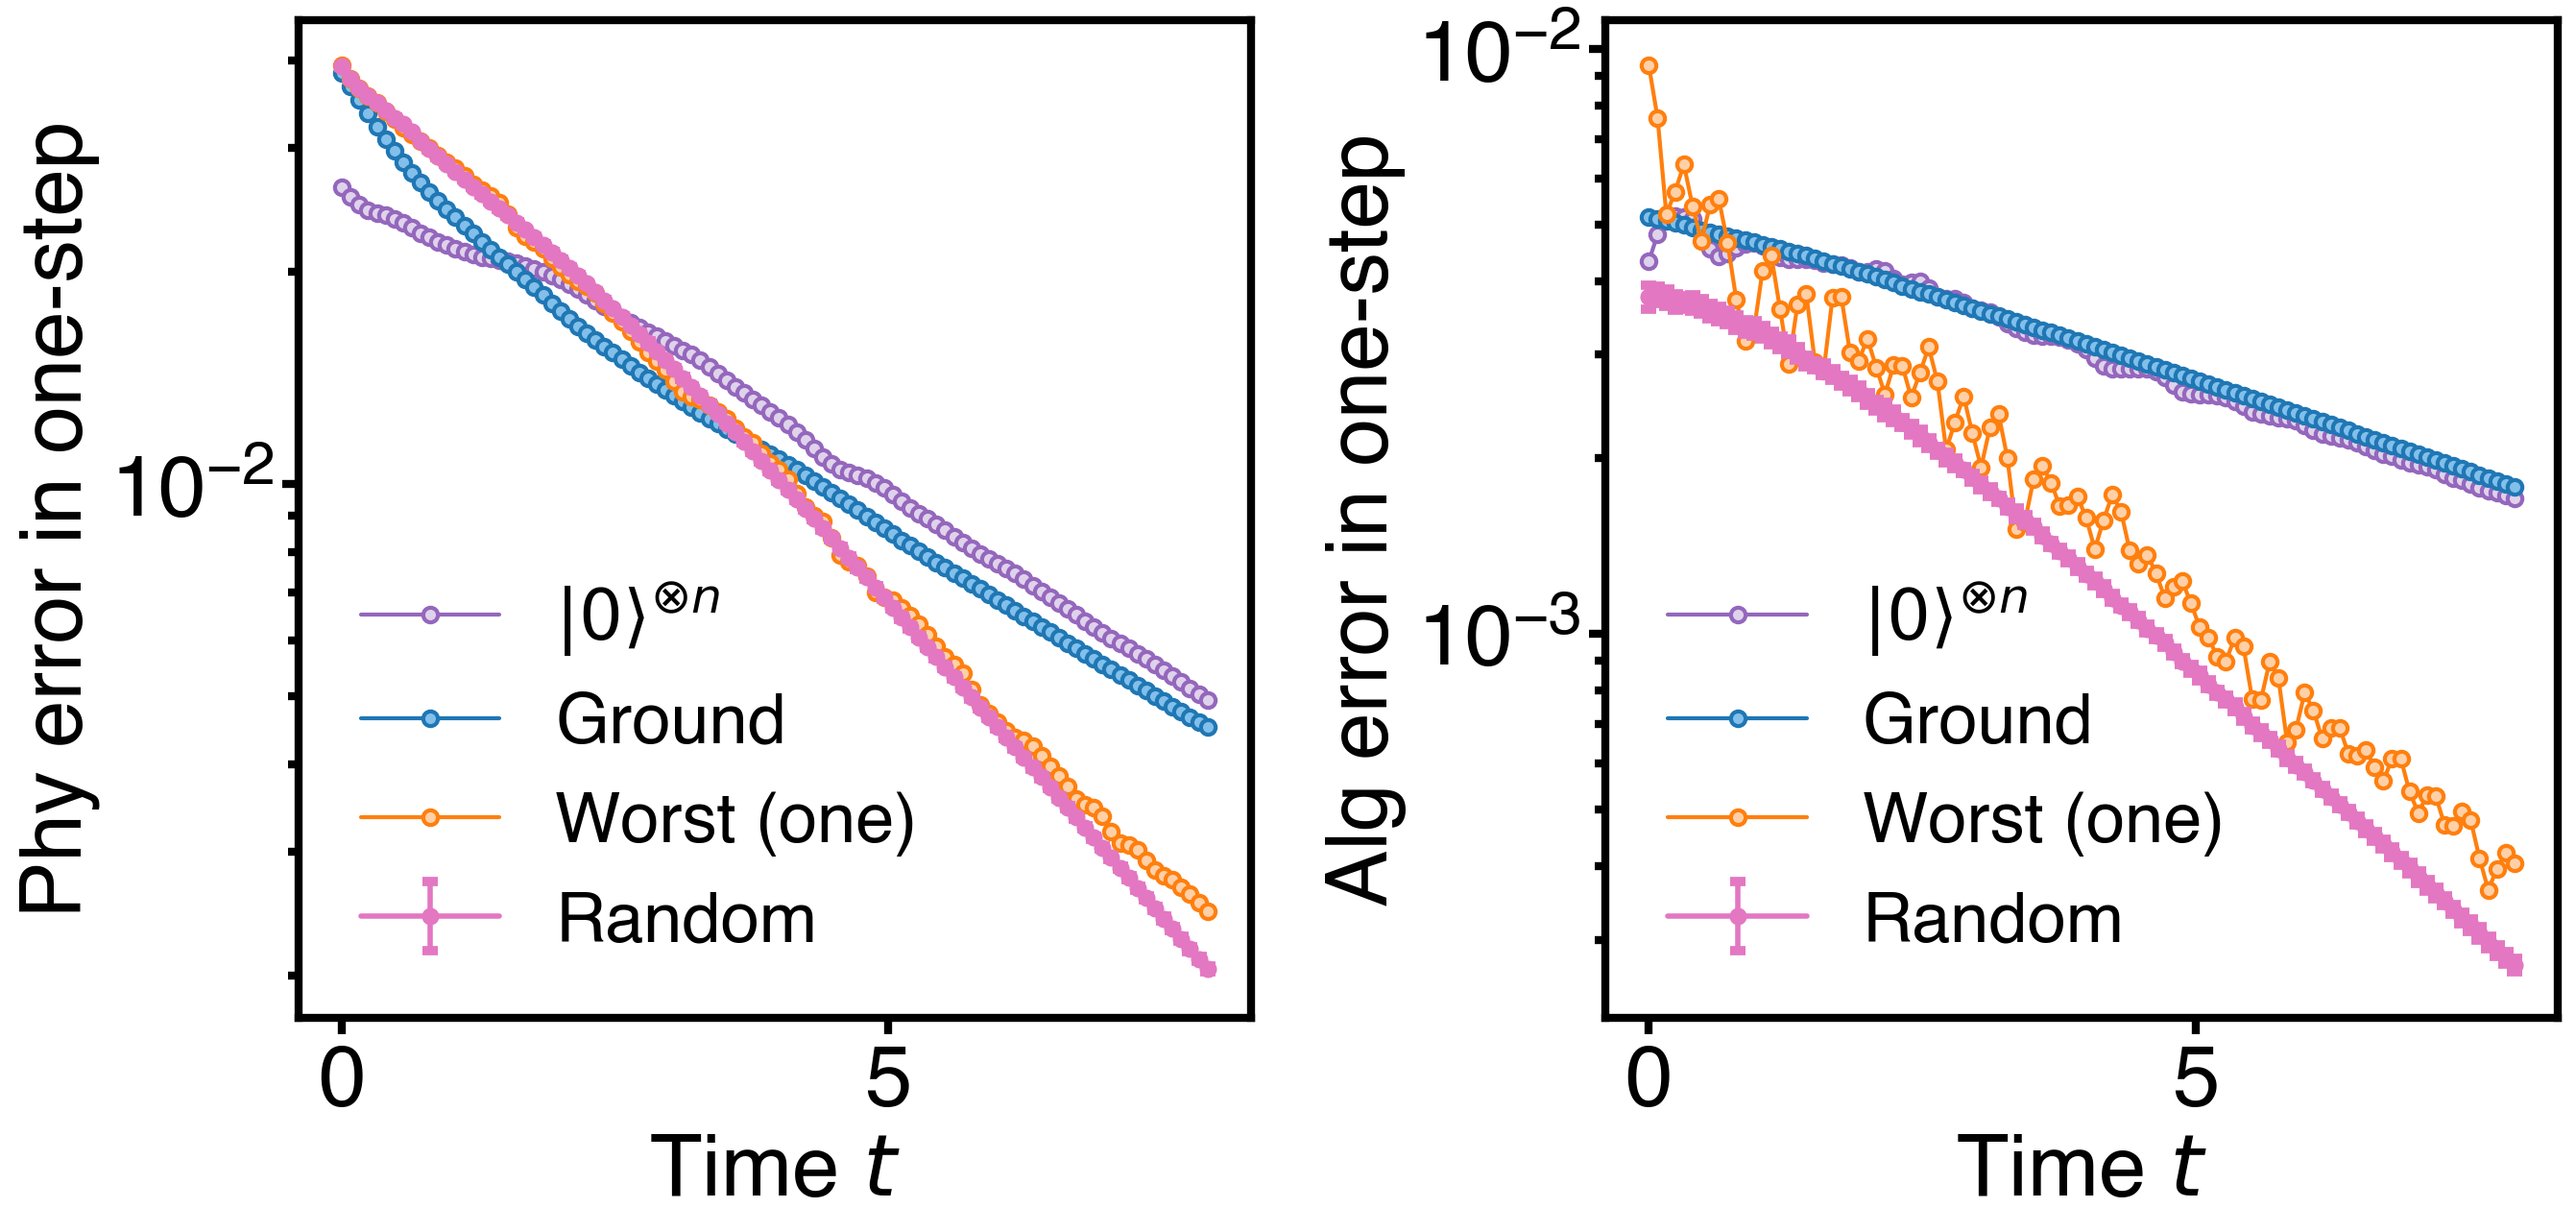

In [5]:
data = np.load(f'{data_dir}/inputs_{model}_{group}_{n}_{gamma}_less_opt.npy', allow_pickle=True).item()

set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=3.0)
mpl.rcParams['legend.frameon'] = False
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
# fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)

plot_evo(axes[0], t_list, data['0']['phy'], '.-', c=cc[0], label=r'$|0\rangle^{\otimes n}$')
plot_evo(axes[0], t_list, data['ground']['phy'], '.-', c=cc[3], label=r'Ground')
plot_evo(axes[0], t_list, data['worst_one']['phy'], '.-', c=cc[4], label=r'Worst (one)')
axes[0].errorbar(t_list, np.mean(data['random']['phy'], axis=0), yerr=np.std(data['random']['phy'], axis=0), fmt='.-', c=cc[6], label=r'Random', capsize=3, lw=2, ms=6)
ax_set_text(axes[0], fr'Time $t$', 'Phy error in one-step', '', legend='lower left', log='y')

plot_evo(axes[1], t_list, data['0']['alg'], '.-', c=cc[0], label=r'$|0\rangle^{\otimes n}$')
plot_evo(axes[1], t_list, data['ground']['alg'], '.-', c=cc[3], label=r'Ground')
plot_evo(axes[1], t_list, data['worst_one']['alg'], '.-', c=cc[4], label=r'Worst (one)')
axes[1].errorbar(t_list, np.mean(data['random']['alg'], axis=0), yerr=np.std(data['random']['alg'], axis=0), fmt='.-', c=cc[6], label=r'Random', capsize=3, lw=2, ms=6)
ax_set_text(axes[1], fr'Time $t$', 'Alg error in one-step', '', legend='lower left', log='y')

fig.savefig(f'{fig_dir}/inputs_{model}_{group}_n={n}_columns_opt.pdf', bbox_inches='tight')